<a href="https://colab.research.google.com/github/KopparapuSaiKalyan/particle-filtering/blob/main/particlefiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q imageio matplotlib opencv-python


Saved GIF to /content/particle_tracking.gif


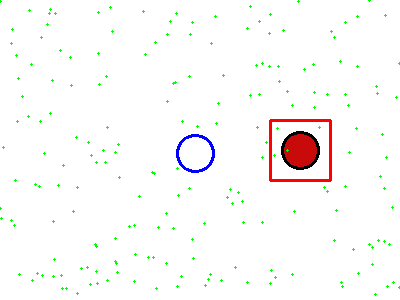

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image, display
import math
import random

W, H = 400, 300
n_frames = 120
ball_radius = 18
process_noise_sigma = 4.0
obs_noise_sigma = 0.0
N = 600
window = 30
lambda_bhat = 20.0

def make_frame(cx, cy, radius=ball_radius):
    """Create a single frame with a red ball at (cx,cy)"""
    img = np.ones((H, W, 3), dtype=np.uint8) * 255
    cv2.circle(img, (int(cx), int(cy)), radius, (10,10,200), -1)
    return img

t = np.linspace(0, 2*math.pi, n_frames)
gt_x = W/2 + 100 * np.cos(0.8*t)
gt_y = H/2 + 60 * np.sin(1.2*t)
frames = [make_frame(gt_x[i], gt_y[i]) for i in range(n_frames)]

particles = np.empty((N, 2), dtype=np.float32)
particles[:, 0] = np.random.uniform(0, W, size=N)
particles[:, 1] = np.random.uniform(0, H, size=N)
weights = np.ones(N, dtype=np.float32) / N

first_frame = frames[0]
x0, y0 = int(gt_x[0]), int(gt_y[0])
x1, y1 = max(0, x0-window), max(0, y0-window)
x2, y2 = min(W-1, x0+window), min(H-1, y0+window)
roi = first_frame[y1:y2, x1:x2]

hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
target_hist = cv2.calcHist([hsv_roi], [0], None, [32], [0, 180])
cv2.normalize(target_hist, target_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

def particle_likelihood(frame, px, py, window=window, target_hist=target_hist):
    x1 = int(max(0, px-window))
    y1 = int(max(0, py-window))
    x2 = int(min(W-1, px+window))
    y2 = int(min(H-1, py+window))
    patch = frame[y1:y2, x1:x2]
    if patch.size == 0:
        return 1e-8
    hsv = cv2.cvtColor(patch, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0], None, [32], [0, 180])
    cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    dist = cv2.compareHist(target_hist, hist, method=cv2.HISTCMP_BHATTACHARYYA)
    weight = np.exp(-lambda_bhat * dist)
    return weight

def systematic_resample(weights):
    N = len(weights)
    positions = (np.arange(N) + np.random.uniform()) / N
    indexes = np.zeros(N, dtype=np.int32)
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

vis_frames = []
est_positions = []

for k in range(n_frames):
    frame = frames[k].copy()

    particles[:, 0] += np.random.normal(0, process_noise_sigma, size=N)
    particles[:, 1] += np.random.normal(0, process_noise_sigma, size=N)

    particles[:, 0] = np.clip(particles[:, 0], 0, W-1)
    particles[:, 1] = np.clip(particles[:, 1], 0, H-1)

    for i in range(N):
        weights[i] = particle_likelihood(frame, particles[i,0], particles[i,1])

    if np.sum(weights) == 0:
        weights = np.ones(N) / N
    else:
        weights += 1e-300
        weights /= np.sum(weights)

    est_x = np.sum(particles[:,0] * weights)
    est_y = np.sum(particles[:,1] * weights)
    est_positions.append((est_x, est_y))

    indexes = systematic_resample(weights)
    particles = particles[indexes]
    weights = np.ones(N, dtype=np.float32) / N

    vis = frame.copy()
    sample_idx = np.random.choice(N, size=min(200, N), replace=False)
    for i in sample_idx:
        cv2.circle(vis, (int(particles[i,0]), int(particles[i,1])), 1, (0, 255, 0), -1)

    cv2.circle(vis, (int(est_x), int(est_y)), ball_radius, (255,0,0), 2)

    cv2.circle(vis, (int(gt_x[k]), int(gt_y[k])), ball_radius, (0,0,0), 2)
    if k == 0:
        cv2.rectangle(vis, (x1,y1), (x2,y2), (0,0,255), 2)

    vis_frames.append(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))

out_gif = "/content/particle_tracking.gif"
imageio.mimsave(out_gif, vis_frames, fps=20)
print("Saved GIF to", out_gif)

display(Image(filename=out_gif))
